In [5]:
import hashlib
import io
import logging
import os
import pickle
import PIL.Image
from PIL import Image
from IPython.display import display
import random
import numpy as np

from object_detection.utils import dataset_util
from object_detection.utils import visualization_utils as vis_util

%run ./variables.ipynb
%run ./utils.ipynb

import tensorflow as tf
from tensorflow import keras
print('Tensorflow version: ', tf.__version__)
print("Eager execution: ", tf.executing_eagerly())
print("Listing CPUs: ", tf.config.list_physical_devices('CPU'))
print("Listing GPUs: ", tf.config.list_physical_devices('GPU'))
print("Listing XLA_GPUs: ", tf.config.list_physical_devices('XLA_GPU'))

Tensorflow version:  2.1.0
Eager execution:  True
Listing CPUs:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Listing GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Listing XLA_GPUs:  [PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]


In [44]:
def create_tf_example(img_file, annotation, masks, id_map, binary=True, segmentation=False, verbose=False):
    ## LOADING IMAGE
    filename = img_file[0]+"."+img_file[1]
    img_path = os.path.join(DATA, PNG_FOLDER, filename)
    encoded_image_data, width, height = load_png(img_path)
    key = hashlib.sha256(encoded_image_data).hexdigest()
    
    if verbose:
        full_image = np.array(Image.open(img_path))
        full_image = np.expand_dims(full_image, -1)
        full_image = np.repeat(full_image, 3, 2)
        full_image = np.array(full_image)
    
    ## GENERAL FEATURES
    image_format = IMG_TYPE.encode('utf8') # b'jpeg' or b'png'
    ## DEFINING BOUNDING BOXES
    xmins = [] # List of normalized left x coordinates in bounding box (1 per box)
    xmaxs = [] # List of normalized right x coordinates in bounding box
    ymins = [] # List of normalized top y coordinates in bounding box (1 per box)
    ymaxs = [] # List of normalized bottom y coordinates in bounding box
    classes_text = [] # List of string class name of bounding box (1 per box)
    classes = [] # List of integer class id of bounding box (1 per box)
    for bb in annotation:
        ymins.append(bb["xmin"]/width)
        ymaxs.append(bb["xmax"]/width)
        xmins.append(bb["ymin"]/height)
        xmaxs.append(bb["ymax"]/height)
        if verbose:
            vis_util.draw_bounding_box_on_image_array(full_image, 
                                             bb["xmin"]/width, 
                                             bb["ymin"]/height,
                                             bb["xmax"]/width,
                                             bb["ymax"]/height,
                                             use_normalized_coordinates=True)
        if binary:
            classes_text.append(next(iter(id_map)).encode('utf8'))
            classes.append(id_map[next(iter(id_map))])
        else:
            classes_text.append(bb["taxon"].encode('utf8'))
            classes.append(map_id[bb["taxon"]])
    
    feature_dict = {
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename.encode('utf8')),
        'image/source_id': dataset_util.bytes_feature(filename.encode('utf8')),
        'image/key/sha256': dataset_util.bytes_feature(key.encode('utf8')),
        'image/encoded': dataset_util.bytes_feature(encoded_image_data),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs)
    }
    
    if segmentation:
        masks_list = []
        for path in masks:
            im = Image.open(os.path.join(DATA, path))
            imgByteArr = io.BytesIO()
            im.save(imgByteArr, format='PNG')
            masks_list.append(imgByteArr.getvalue())
            if verbose:
                img_pil = Image.open(imgByteArr)
                img_pil = np.array(img_pil)
                vis_util.draw_mask_on_image_array(full_image,img_pil)
        feature_dict['image/object/mask']=dataset_util.bytes_list_feature(masks_list)
    
    if verbose:
        display(Image.fromarray(full_image))
        
    tf_example = tf.train.Example(features=tf.train.Features(feature=feature_dict))
    return tf_example

In [45]:
def create_tf_record(img_files, output_path, binary=True, segmentation=False, verbose=False):
    if binary:
        pb_name = "binary_label_map.pbtxt"
        id_map = pickle.load(open(os.path.join(DATA, MAPS_FOLDER, "binary_label_map.pickle"), "rb" ))
    else:
        pb_name = "multiclass_label_map.pbtxt"
        id_map = pickle.load(open(os.path.join(DATA, MAPS_FOLDER, "multiclass_label_map.pickle"), "rb" ))
    writer = tf.io.TFRecordWriter(output_path)
    i = 1;
    print("Creating tfrecord based on "+str(len(img_files))+" example(s). Save location: "+output_path)
    print("0 %")
    for image in img_files:
        if i%(len(img_files)/5)==0:
            print(int(i/len(img_files)*100),"%")
        bb_path = os.path.join(DATA, ANNOTATIONS_FOLDER, "bb_"+image[0]+".pickle")
        masks_path = os.path.join(DATA, ANNOTATIONS_FOLDER, "masks_"+image[0]+".pickle")
        if os.path.isfile(bb_path) and os.path.isfile(masks_path):
            bb = pickle.load(open(bb_path, "rb"))
            masks = pickle.load(open(masks_path, "rb"))
            tf_example = create_tf_example(image, bb, masks, id_map, binary=binary, segmentation=segmentation, verbose=verbose)
            writer.write(tf_example.SerializeToString())
        else:
            print("WARNING: Image ", image[0], ".", image[1], " has no associated annotation file. Ignoring image.")
        i += 1
    writer.close()
    create_pbtxt(id_map, OUPUT_PATH+'/'+pb_name)
    print("Finished!")

Creating tfrecord based on 160 example(s). Save location: ./tf_records/train_dataset.record
0 %


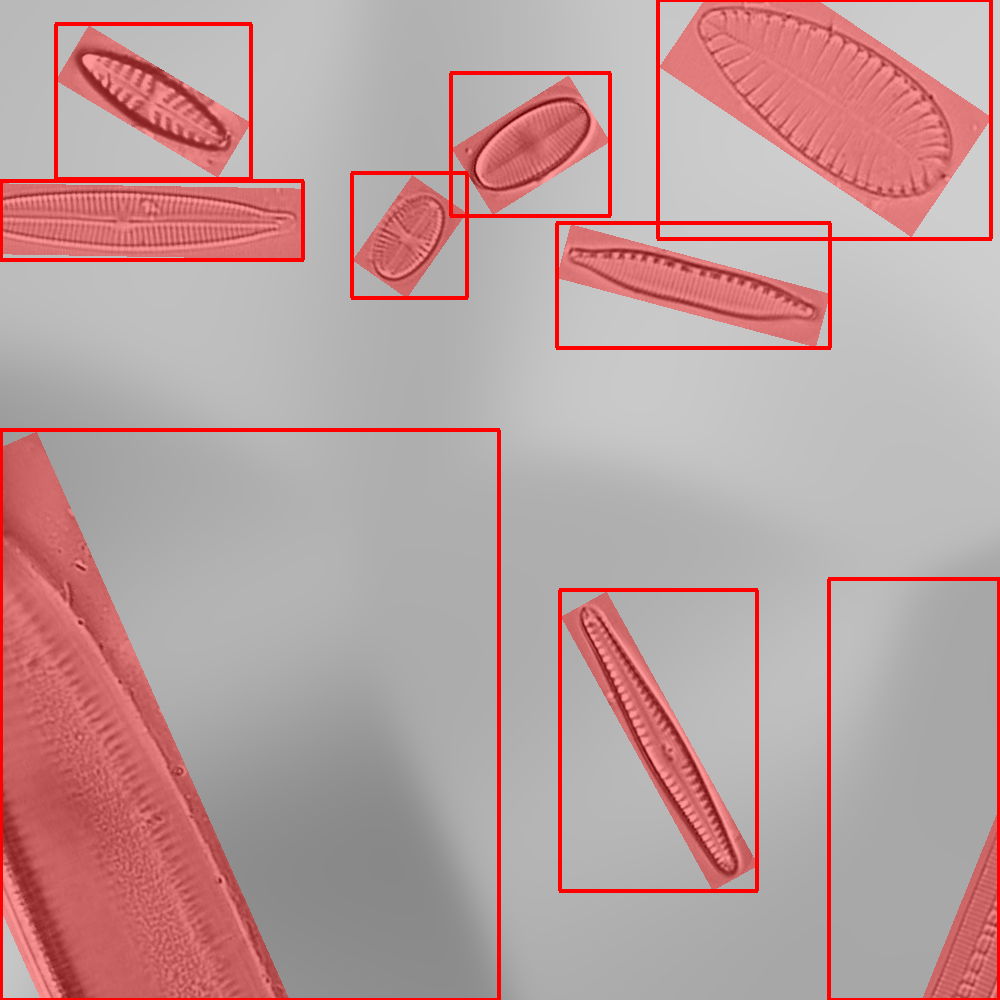

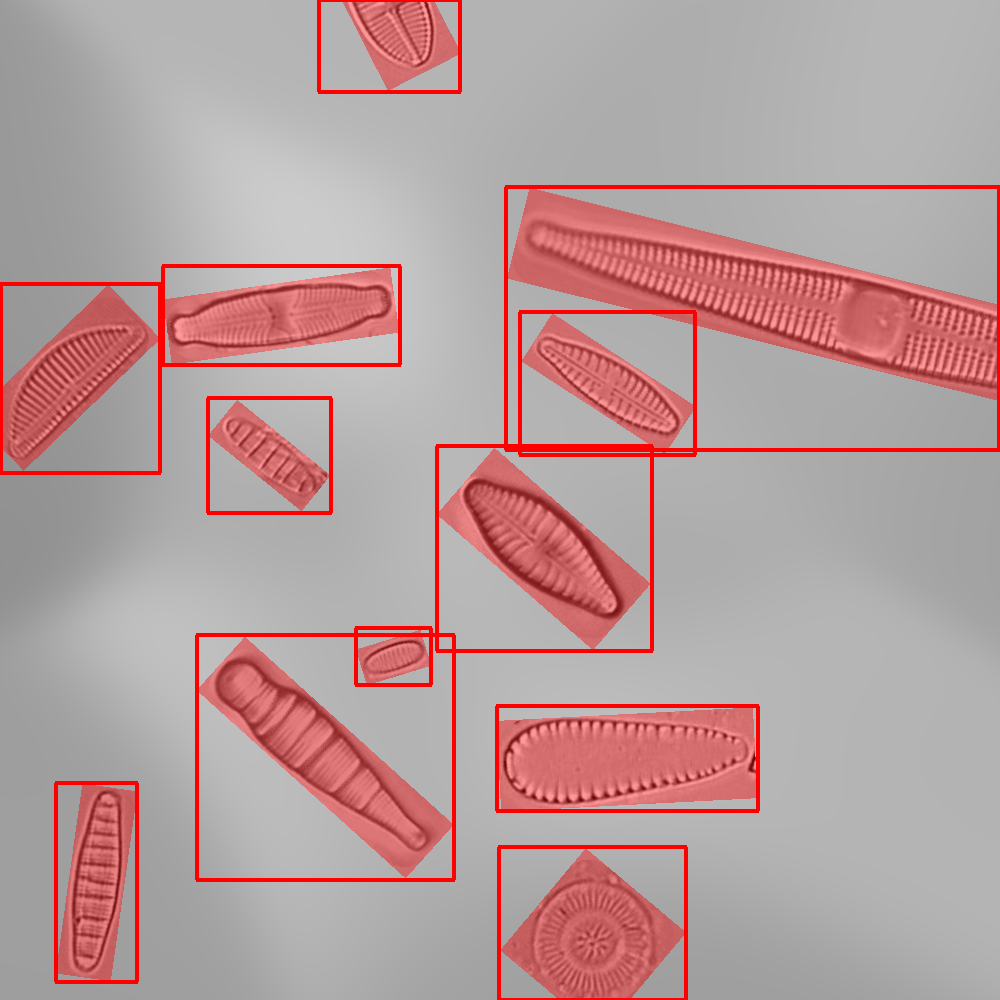

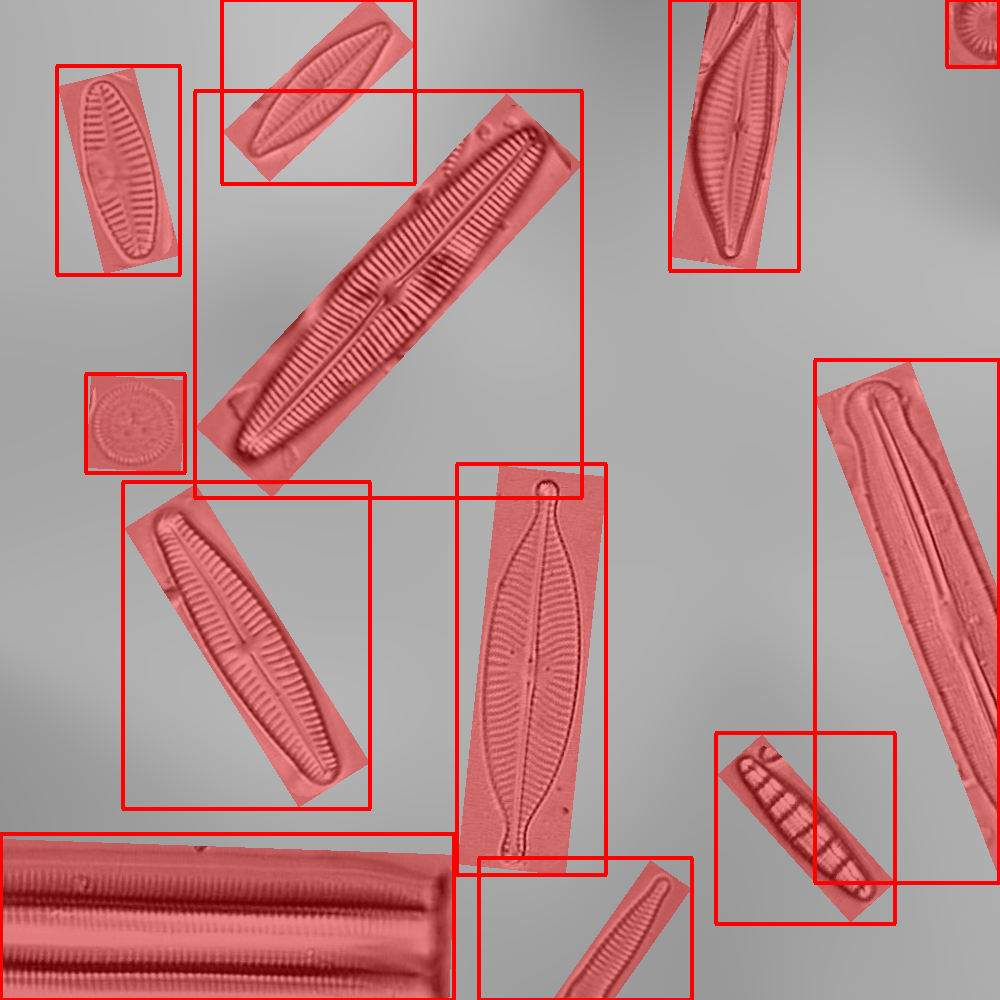

KeyboardInterrupt: 

In [46]:
# LISTING ALL EXAMPLES FROM THE IMAGE FOLDER
img_path = os.path.join(DATA, PNG_FOLDER)
images = []
for (dirpath, dirnames, filenames) in os.walk(img_path):
    for filename in filenames:
        splitted = filename.split('.')
        if len(splitted) and splitted[1].lower()=="png":
            images.append([splitted[0], splitted[1]])
random.shuffle(images)
last_index = len(images)
# Creating test and train dataset
binary_dataset = True
segmentation = True
verbose = False
create_tf_record(images[0:int(PERCENTAGE_TRAIN*len(images))], TRAIN_OUTPUT_PATH, binary=binary_dataset, segmentation=True, verbose=verbose)
create_tf_record(images[int(PERCENTAGE_TRAIN*len(images)):len(images)], TEST_OUTPUT_PATH, binary=binary_dataset, segmentation=True, verbose=verbose)